In [1]:
import pandas as pd
import numpy as np
import re
import datetime
import seaborn as sns
from matplotlib import pyplot as plt


In [2]:
DIR_ = "D:/Drive/OneDrive/Documents/MIMIC"
DIR = "D:/Workspace/MIMIC_DATA/mimic-iii-clinical-database-1.4/"

In [3]:
adm_notes = pd.read_csv(DIR + "readmission.csv", low_memory=False)

In [4]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


# Natural Language

In [5]:
import string
import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [6]:
def clean_text(texts):
    texts = texts.fillna(' ')
    texts = texts.str.replace('\n',' ')
    texts = texts.str.replace('\r',' ')

    table = str.maketrans('', '', string.punctuation + '0123456789')
    texts = [text.lower().translate(table) for text in texts]

    return texts

In [7]:
adm_notes['TEXT'] = clean_text(adm_notes['TEXT'])

In [8]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
stop_words = stopwords.words('english')
stop_words = stop_words + ['patient', 'date', 'admission', 'discharge', 'lastname', 'firstname', 'sex']

In [10]:
porter = PorterStemmer()

In [11]:
def tokenize_stem(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [porter.stem(word) for word in words]
    return words

In [12]:
for i, text in enumerate(adm_notes['TEXT']):
   adm_notes.loc[i, 'TEXT'] = (' ').join(tokenize_stem(adm_notes['TEXT'][i]))

# Model
## Words, Train and Test

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

Repartition data

In [14]:
df_train, df_test = train_test_split(adm_notes, test_size=0.2, random_state=42)

Subsample non-readmitted patients to match size of readmitted ones

In [15]:
rows_pos = df_train['READM_WITHIN_30'] == 1
df_train_pos = df_train.loc[rows_pos]
df_train_neg = df_train.loc[~rows_pos]

df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos))], axis = 0)
df_train = df_train.sample(n = len(df_train)).reset_index(drop = True)

In [16]:
rows_pos = df_test['READM_WITHIN_30'] == 1
df_test_pos = df_test.loc[rows_pos]
df_test_neg = df_test.loc[~rows_pos]

df_test = pd.concat([df_test_pos, df_test_neg.sample(n = len(df_test_pos))], axis = 0)
df_test = df_test.sample(n = len(df_test)).reset_index(drop = True)

In [17]:
print(df_train.shape)
print(df_test.shape)

(4724, 10)
(1202, 10)


Sparse Matrix with word count

# Recurrent Neural Network

In [18]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Conv1D, MaxPooling1D, SpatialDropout1D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf


In [19]:
NUMBER_WORDS = 5000

tokenizer = Tokenizer(num_words=NUMBER_WORDS)
tokenizer.fit_on_texts(df_train['TEXT'])
sequences_train = tokenizer.texts_to_sequences(df_train['TEXT'])
sequences_test = tokenizer.texts_to_sequences(df_test['TEXT'])

X_train = pad_sequences(sequences_train, maxlen=NUMBER_WORDS)
X_test = pad_sequences(sequences_test, maxlen=NUMBER_WORDS)

In [20]:
y_train = to_categorical(df_train['READM_WITHIN_30'])
y_test = to_categorical(df_test['READM_WITHIN_30'])

In [21]:
adam = Adam(learning_rate=0.00001)

In [23]:
model = Sequential()

model.add(Embedding(input_dim=X_train.shape[1], output_dim=32, input_length=X_train.shape[1]))

model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(2, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 5000, 32)          160000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 168,386
Trainable params: 168,386
Non-trainable params: 0
_________________________________________________________________


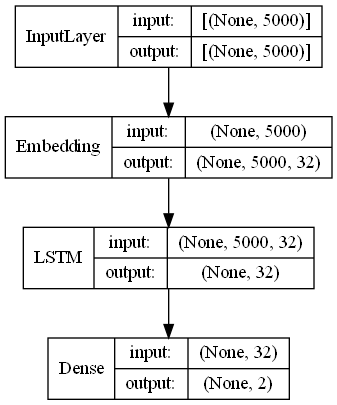

In [24]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=False)

In [25]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 64, validation_split=0.2)

Epoch 1/100
60/60 [==============================] - 454s 8s/step - loss: 0.6915 - accuracy: 0.5277 - val_loss: 0.6899 - val_accuracy: 0.5471
Epoch 2/100
60/60 [==============================] - 633s 11s/step - loss: 0.6783 - accuracy: 0.5827 - val_loss: 0.6833 - val_accuracy: 0.5725
Epoch 3/100
60/60 [==============================] - 648s 11s/step - loss: 0.6544 - accuracy: 0.6388 - val_loss: 0.6803 - val_accuracy: 0.5958
Epoch 4/100
60/60 [==============================] - 644s 11s/step - loss: 0.6169 - accuracy: 0.6798 - val_loss: 0.6886 - val_accuracy: 0.5862
Epoch 5/100
60/60 [==============================] - 639s 11s/step - loss: 0.5694 - accuracy: 0.7166 - val_loss: 0.6988 - val_accuracy: 0.5862
Epoch 6/100
60/60 [==============================] - 642s 11s/step - loss: 0.5205 - accuracy: 0.7547 - val_loss: 0.7364 - val_accuracy: 0.6032
Epoch 7/100
60/60 [==============================] - 666s 11s/step - loss: 0.4777 - accuracy: 0.7899 - val_loss: 0.8512 - val_accuracy: 0.5757


Epoch 58/100
60/60 [==============================] - 632s 11s/step - loss: 0.1014 - accuracy: 0.9600 - val_loss: 1.9649 - val_accuracy: 0.5672
Epoch 59/100
60/60 [==============================] - 629s 10s/step - loss: 0.0824 - accuracy: 0.9701 - val_loss: 2.0601 - val_accuracy: 0.5608
Epoch 60/100
60/60 [==============================] - 631s 11s/step - loss: 0.1069 - accuracy: 0.9574 - val_loss: 1.9162 - val_accuracy: 0.5630
Epoch 61/100
60/60 [==============================] - 623s 10s/step - loss: 0.0797 - accuracy: 0.9696 - val_loss: 2.0082 - val_accuracy: 0.5651
Epoch 62/100
60/60 [==============================] - 625s 10s/step - loss: 0.0717 - accuracy: 0.9717 - val_loss: 2.1764 - val_accuracy: 0.5778
Epoch 63/100
60/60 [==============================] - 622s 10s/step - loss: 0.0776 - accuracy: 0.9712 - val_loss: 2.0329 - val_accuracy: 0.5630
Epoch 64/100
60/60 [==============================] - 622s 10s/step - loss: 0.0762 - accuracy: 0.9714 - val_loss: 2.2005 - val_accuracy:

In [26]:
print(model.metrics_names)
model.evaluate(X_test, y_test, batch_size=64)

['loss', 'accuracy']
19/19 [==============================] - 10s 534ms/step - loss: 2.8893 - accuracy: 0.5641


[2.88932728767395, 0.5640599131584167]

In [27]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

y_test_raw = df_test['READM_WITHIN_30']

print(classification_report(y_test_raw, y_pred, digits=3))
print(roc_auc_score(y_test_raw, y_pred))

19/19 [==============================] - 12s 560ms/step
              precision    recall  f1-score   support

           0      0.571     0.514     0.541       601
           1      0.558     0.614     0.585       601

    accuracy                          0.564      1202
   macro avg      0.565     0.564     0.563      1202
weighted avg      0.565     0.564     0.563      1202

0.5640599001663893


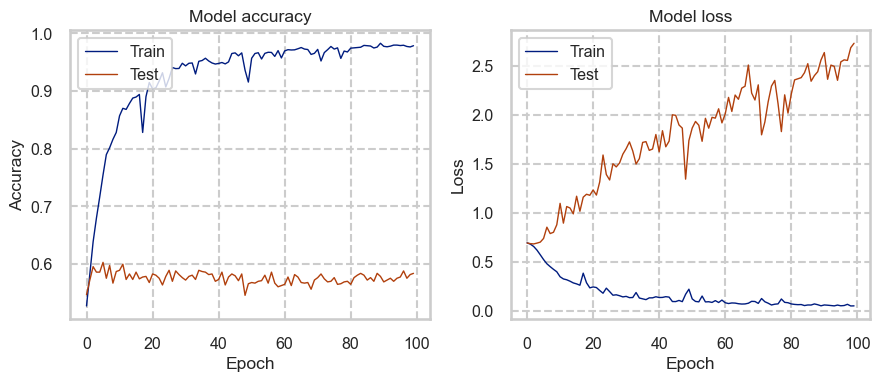

In [28]:
sns.set('talk', 'whitegrid', 'dark', font_scale=0.7,
        rc={"lines.linewidth": 1, 'grid.linestyle': '--'})

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Test'], loc='upper left')

fig.tight_layout()
plt.show()